In [1]:
from typing import Optional, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from numpy.polynomial import Polynomial
from numpy.typing import ArrayLike, NDArray
from scipy.stats import rv_continuous
from scipy.stats.sampling import NumericalInverseHermite

In [2]:
RNG = Union[int, np.random.Generator, np.random.RandomState]


class _SampleCoherence(rv_continuous):
    """
    """
    
    def _argcheck(
        self,
        coherence: NDArray[np.floating],
        numlooks: NDArray[np.floating],
    ) -> NDArray[np.bool_]:
        """ """
        return (coherence >= 0.0) & (coherence <= 1.0) & (numlooks >= 2.0)
    
    def _pdf(
        self,
        x: NDArray[np.floating],
        coherence: NDArray[np.floating],
        numlooks: NDArray[np.floating],
    ) -> NDArray[np.floating]:
        """ """
        coh_sq = coherence**2
        x_sq = x**2
        
        c1 = 2.0 * (numlooks - 1.0) * (1.0 - coh_sq) ** numlooks
        c2 = x * (1.0 - x_sq) ** (numlooks - 2.0)
        c3 = sc.hyp2f1(numlooks, numlooks, 1.0, coh_sq * x_sq)
        
        return c1 * c2 * c3
    
    def _rvs(
        self,
        coherence: NDArray[np.floating],
        numlooks: NDArray[np.floating],
        size: Optional[Union[int, Tuple[int, ...]]],
        random_state: Optional[RNG],
    ) -> NDArray[np.floating]:
        """ """
        dist = self(coherence=coherence, numlooks=numlooks)
        hinv = NumericalInverseHermite(
            dist,
            domain=dist.support(),
            u_resolution=1e-10,
            random_state=random_state,
        )
        return hinv.rvs(size=size)


SampleCoherence = _SampleCoherence(
    a=0.0,
    b=1.0,
    name="SampleCoherence",
)


def rmse(y_hat: ArrayLike, y: ArrayLike) -> NDArray[np.floating]:
    """ """
    return np.sqrt(np.mean(np.square(np.subtract(y, y_hat))))

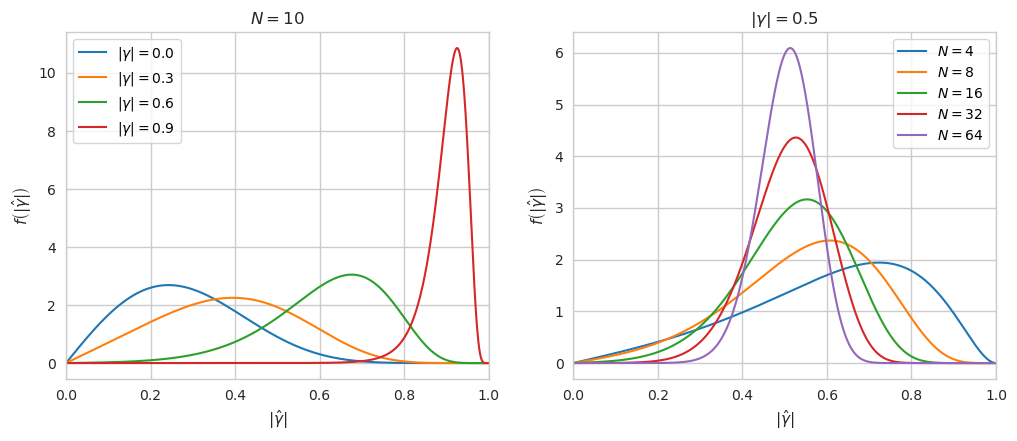

In [3]:
with plt.style.context("seaborn-notebook"), plt.style.context("seaborn-whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

gamma_hat = np.linspace(0.0, 1.0, num=1001)

numlooks = 10.0
axes[0].set_title(rf"$N = {numlooks:.0f}$")
for coherence in [0.0, 0.3, 0.6, 0.9]:
    rv = SampleCoherence(coherence=coherence, numlooks=numlooks)
    f = rv.pdf(gamma_hat)
    axes[0].plot(gamma_hat, f, label=rf"$|\gamma| = {coherence:.1f}$")

coherence = 0.5
axes[1].set_title(rf"$|\gamma| = {coherence:.1f}$")
for numlooks in [4.0, 8.0, 16.0, 32.0, 64.0]:
    rv = SampleCoherence(coherence=coherence, numlooks=numlooks)
    f = rv.pdf(gamma_hat)
    axes[1].plot(gamma_hat, f, label=rf"$N = {numlooks:.0f}$")

for ax in axes.flat:
    ax.set_xlim([0.0, 1.0])
    ax.set_xlabel(r"$|\hat{\gamma}|$")
    ax.set_ylabel(r"$f\left(|\hat{\gamma}|\right)$")
    ax.legend()

plt.show()

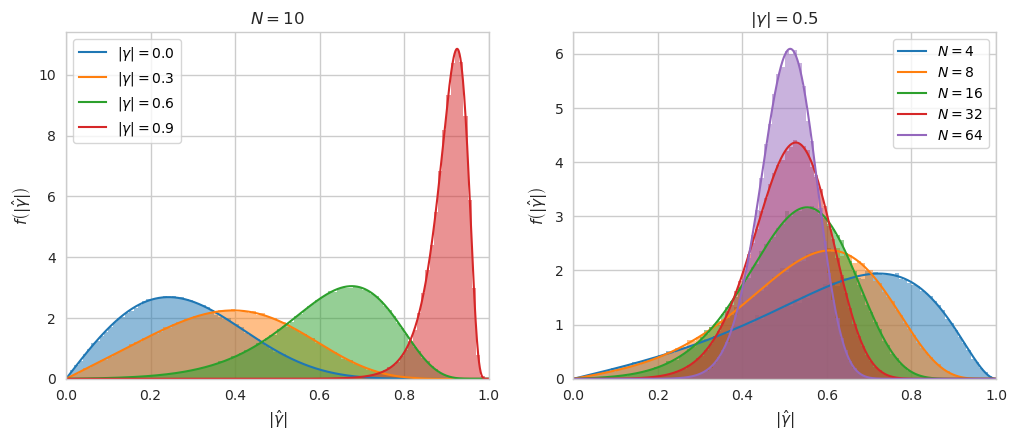

In [4]:
with plt.style.context("seaborn-notebook"), plt.style.context("seaborn-whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

palette = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
gamma_hat = np.linspace(0.0, 1.0, num=1001)

numlooks = 10.0
axes[0].set_title(rf"$N = {numlooks:.0f}$")
for coherence, color in zip([0.0, 0.3, 0.6, 0.9], palette):
    rv = SampleCoherence(coherence=coherence, numlooks=numlooks)
    f = rv.pdf(gamma_hat)
    axes[0].plot(gamma_hat, f, color=color, label=rf"$|\gamma| = {coherence:.1f}$")
    samples = rv.rvs(size=1<<17)
    axes[0].hist(samples, bins=100, range=[0.0, 1.0], density=True, color=color, alpha=0.5)

coherence = 0.5
axes[1].set_title(rf"$|\gamma| = {coherence:.1f}$")
for numlooks, color in zip([4.0, 8.0, 16.0, 32.0, 64.0], palette):
    rv = SampleCoherence(coherence=coherence, numlooks=numlooks)
    f = rv.pdf(gamma_hat)
    axes[1].plot(gamma_hat, f, label=rf"$N = {numlooks:.0f}$")
    samples = rv.rvs(size=1<<17)
    axes[1].hist(samples, bins=100, range=[0.0, 1.0], density=True, color=color, alpha=0.5)

for ax in axes.flat:
    ax.set_xlim([0.0, 1.0])
    ax.set_xlabel(r"$|\hat{\gamma}|$")
    ax.set_ylabel(r"$f\left(|\hat{\gamma}|\right)$")
    ax.legend()

plt.show()

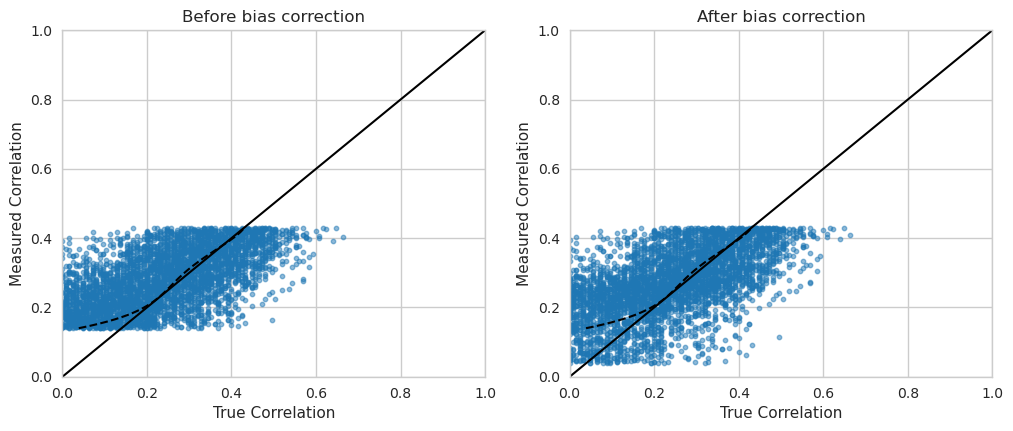

RMSE before bias correction: 0.11550344649799178
RMSE after  bias correction: 0.11485529994916754


In [5]:
numlooks = 35.0
coherence = np.linspace(0.0, 0.8, num=101)
sample_coherence = np.asarray([
    SampleCoherence(coherence=x, numlooks=numlooks).rvs(size=100)
    for x in coherence
])

coherence_flat = np.broadcast_to(coherence[:, None], sample_coherence.shape).flatten()
sample_coherence_flat = sample_coherence.flatten()

poly = Polynomial([
    -1.6185, 
    23.3193,
    -112.4498,
    244.5408,
    -193.906,
])
sample_coherence_flat_corrected = poly(sample_coherence_flat)

mask = (sample_coherence_flat > 0.14) & (sample_coherence_flat < 0.43)

with plt.style.context("seaborn-notebook"), plt.style.context("seaborn-whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

for ax in axes.flat:
    ax.plot([0.0, 1.0], [0.0, 1.0], color="black")
    rho = np.linspace(0.14, 0.43, num=1001)
    ax.plot(poly(rho), rho, color="black", linestyle="--")

axes[0].set_title("Before bias correction")
axes[0].scatter(coherence_flat[mask], sample_coherence_flat[mask], s=10.0, alpha=0.5)

axes[1].set_title("After bias correction")
axes[1].scatter(coherence_flat[mask], sample_coherence_flat_corrected[mask], s=10.0, alpha=0.5)

for ax in axes.flat:
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("True Correlation")
    ax.set_ylabel("Measured Correlation")

plt.show()

print(f"RMSE before bias correction: {rmse(sample_coherence_flat[mask], coherence_flat[mask])}")
print(f"RMSE after  bias correction: {rmse(sample_coherence_flat_corrected[mask], coherence_flat[mask])}")